In [35]:
import gdelt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import yfinance as yf

In [36]:
gd = gdelt.gdelt(version=2)

## Per day worldwide sentiment and count analysis

In [37]:
day = '2024 01 03'
results = gd.Search(day, table='events', coverage=True);


here
here
here
here
herehere

here
here
here
here
here
here
here
here
here
here


In [38]:
results.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate',
       'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'CAMEOCodeDescription', 'EventBaseCode', 'EventRootCode',
       'QuadClass', 'GoldsteinScale', 'NumMentions', 'NumSources',
       'NumArticles', 'AvgTone', 'Actor1Geo_Type', 'Actor1Geo_FullName',
       'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code', 'Actor1Geo_ADM2Code',
       'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor1Geo_FeatureID',
       'Actor2Geo_Type', 'Actor2Geo_FullName', 'Actor2Geo_CountryCode',
       'Actor2Geo_ADM1Code', 'Actor2Geo_ADM2Code

In [39]:
results[:10]


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,1149449682,20230103,202301,2023,2023.0082,NaN,NaN,NaN,NaN,NaN,...,2,"Idaho, United States",US,USID,NaN,44.2394,-114.5100,ID,20240103031500,https://www.postregister.com/news/education/k-...
1,1149449683,20230103,202301,2023,2023.0082,NaN,NaN,NaN,NaN,NaN,...,4,"Chitwan, Nepal (general), Nepal",NP,NP00,22353,27.5833,84.5000,-1021849,20240103031500,https://www.peoplesreview.com.np/2024/01/03/ne...
2,1149449684,20230103,202301,2023,2023.0082,NaN,NaN,NaN,NaN,NaN,...,4,"Bathnaha, Bihar, India",IN,IN34,70094,26.3500,87.2333,-2090805,20240103031500,https://www.peoplesreview.com.np/2024/01/03/ne...
3,1149449685,20230103,202301,2023,2023.0082,NaN,NaN,NaN,NaN,NaN,...,4,"Bathnaha, Bihar, India",IN,IN34,70094,26.3500,87.2333,-2090805,20240103031500,https://www.peoplesreview.com.np/2024/01/03/ne...
4,1149449686,20230103,202301,2023,2023.0082,CVL,TOURIST,NaN,NaN,NaN,...,4,"Antalya, Antalya, Turkey",TU,TU07,27547,36.9081,30.6956,-735347,20240103031500,https://menafn.com/1107678524/Number-Of-Touris...
5,1149449687,20230103,202301,2023,2023.0082,CVL,RESIDENTS,NaN,NaN,NaN,...,3,"Dallas, Texas, United States",US,USTX,TX113,32.7831,-96.8067,1380944,20240103031500,https://www.bnnbloomberg.ca/buyout-firm-advent...
6,1149449688,20230103,202301,2023,2023.0082,CVL,RESIDENTS,NaN,NaN,NaN,...,3,"Dallas, Texas, United States",US,USTX,TX113,32.7831,-96.8067,1380944,20240103031500,https://www.bnnbloomberg.ca/buyout-firm-advent...
7,1149449689,20230103,202301,2023,2023.0082,EDU,SCHOOL,NaN,NaN,NaN,...,2,"Idaho, United States",US,USID,NaN,44.2394,-114.5100,ID,20240103031500,https://www.postregister.com/news/education/k-...
8,1149449690,20230103,202301,2023,2023.0082,EDU,SCHOOL,NaN,NaN,NaN,...,2,"Idaho, United States",US,USID,NaN,44.2394,-114.5100,ID,20240103031500,https://www.postregister.com/news/education/k-...
9,1149449691,20230103,202301,2023,2023.0082,TUR,ANTALYA,TUR,NaN,NaN,...,4,"Antalya, Antalya, Turkey",TU,TU07,27547,36.9081,30.6956,-735347,20240103031500,https://menafn.com/1107678524/Number-Of-Touris...


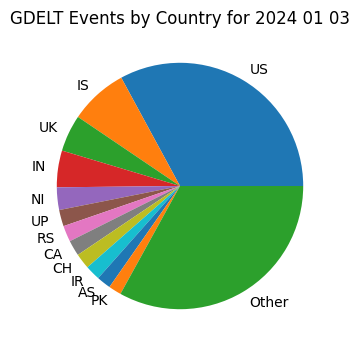

In [40]:
country_counts = results['ActionGeo_CountryCode'].value_counts()

# Get the top 12 countries
top_countries = country_counts[:12]

# Combine the counts of countries not in the top 12
other_count = country_counts[12:].sum()

# Create a new series with the top countries and "Other"
grouped_country_counts = pd.concat([top_countries, pd.Series([other_count], index=['Other'])])

plt.figure(figsize=(4, 4))
plt.title(f'GDELT Events by Country for {day}')
plt.pie(grouped_country_counts, labels=grouped_country_counts.index)

# Save figure
plt.savefig('./plots/event_count_piechart.png')

plt.show()

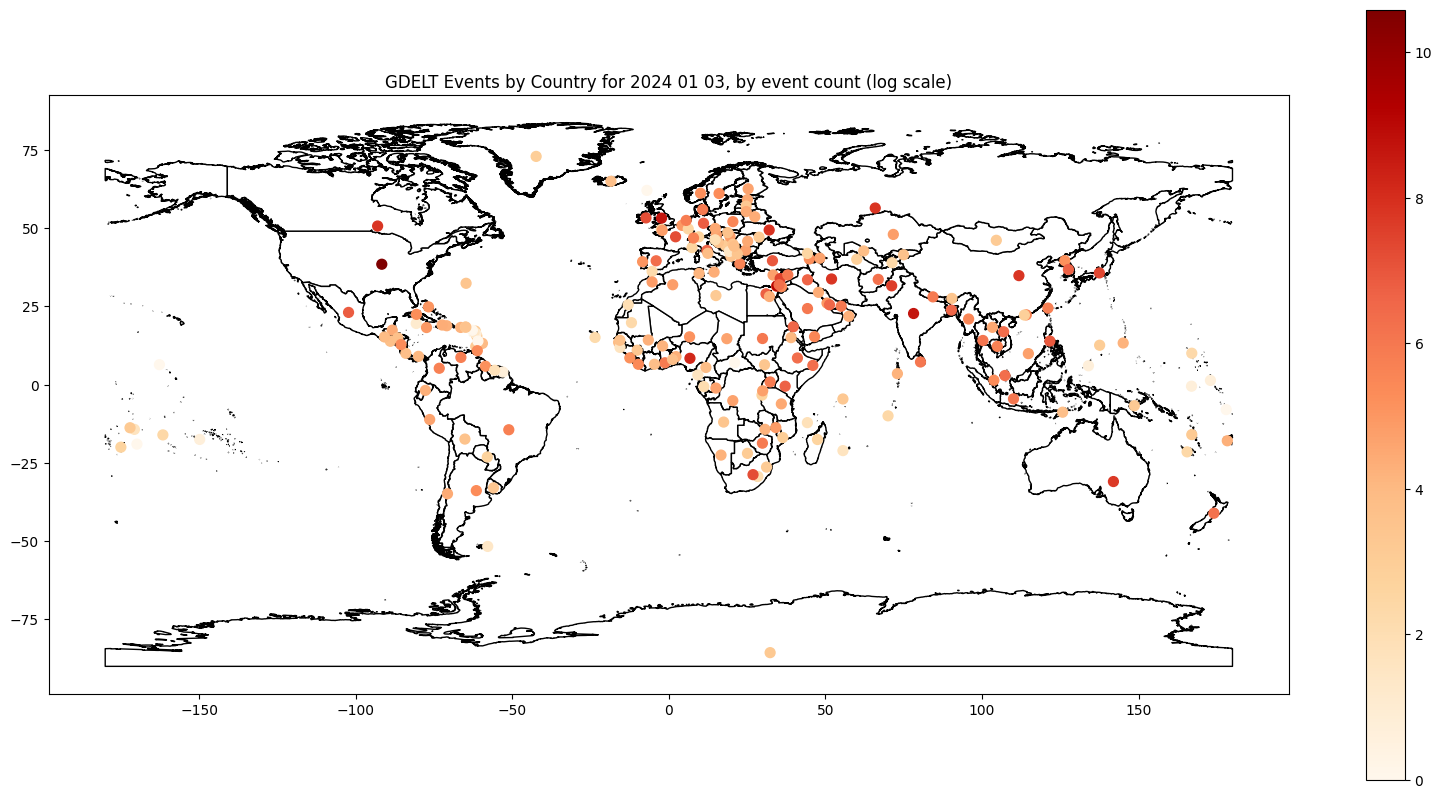

In [41]:
# Plot the event per country
# First average the lat and long for each country and sum the number of events
country_events = results.groupby('ActionGeo_CountryCode').agg({'ActionGeo_Lat': 'mean', 'ActionGeo_Long': 'mean', 'GLOBALEVENTID': 'count'})

# Convert to a geodataframe
country_events = gpd.GeoDataFrame(country_events, geometry=gpd.points_from_xy(country_events['ActionGeo_Long'], country_events['ActionGeo_Lat']))

# Load the world map
world = gpd.read_file('./ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')

# Plot the world map
ax = world.plot(color='white', edgecolor='black', figsize=(20, 10))

# Plot the country events
country_events.plot(ax=ax, column=np.log(country_events['GLOBALEVENTID']), cmap='OrRd', markersize=50, legend=True)

# Add a title
plt.title(f'GDELT Events by Country for {day}, by event count (log scale)')

# Save figure
plt.savefig('./plots/world_event_count.png')

plt.show()

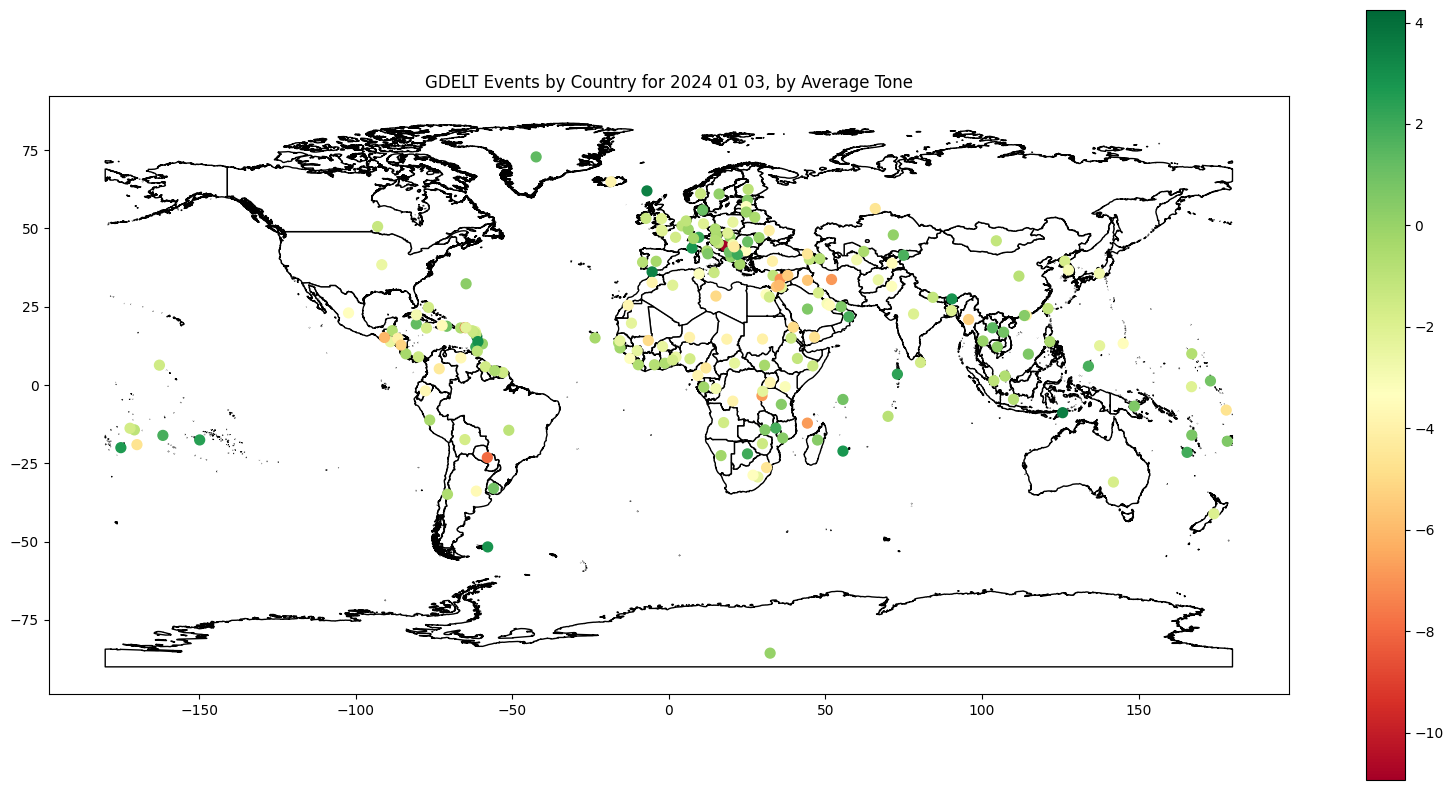

In [42]:
# Plot events per country on a map, coloured by average tone

# First average the lat and long for each country and sum the number of events
country_events = results.groupby('ActionGeo_CountryCode').agg({'ActionGeo_Lat': 'mean', 'ActionGeo_Long': 'mean', 'AvgTone': 'mean'})

# Convert to a geodataframe
country_events = gpd.GeoDataFrame(country_events, geometry=gpd.points_from_xy(country_events['ActionGeo_Long'], country_events['ActionGeo_Lat']))

# Load the world map
world = gpd.read_file('./ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')

# Plot the world map
ax = world.plot(color='white', edgecolor='black', figsize=(20, 10))

# Plot the country events
country_events.plot(ax=ax, column=country_events['AvgTone'], cmap='RdYlGn', markersize=50, legend=True)

# Add a title
plt.title(f'GDELT Events by Country for {day}, by Average Tone')

# Save figure
plt.savefig('./plots/world_sentiment.png')

plt.show()


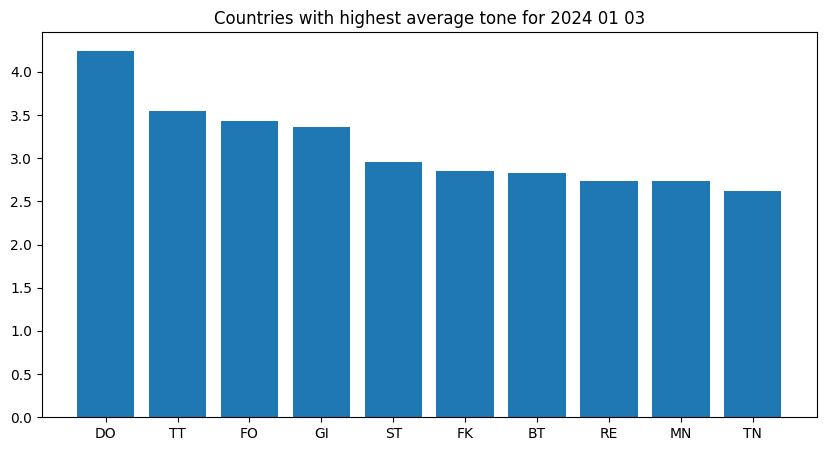

In [43]:
# Find the countries with top 10 highest average tone and plot on bar chart
top_countries = country_events.sort_values('AvgTone', ascending=False)[:10]

plt.figure(figsize=(10, 5))
plt.title(f'Countries with highest average tone for {day}')
plt.bar(top_countries.index, top_countries['AvgTone'])

# Save figure
plt.savefig('./plots/top_countries.png')

plt.show()

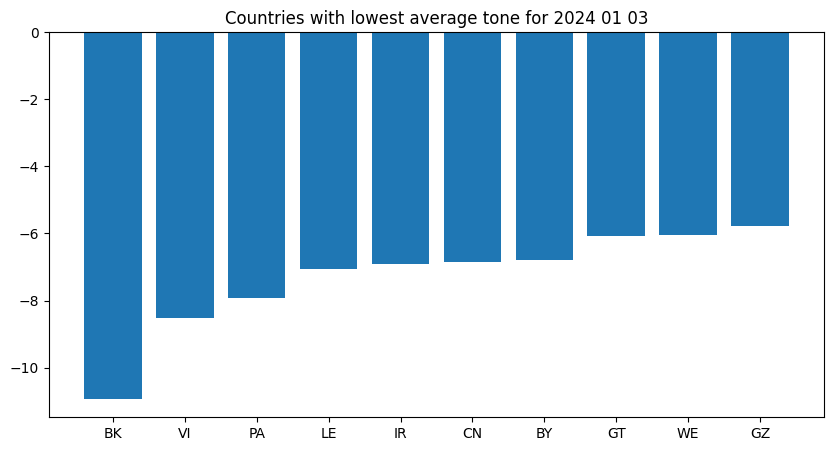

In [44]:
# Find the countries with top 10 lowest average tone and plot on bar chart
bottom_countries = country_events.sort_values('AvgTone')[:10]

plt.figure(figsize=(10, 5))
plt.title(f'Countries with lowest average tone for {day}')
plt.bar(bottom_countries.index, bottom_countries['AvgTone'])

# Save figure
plt.savefig('./plots/bottom_countries.png')

plt.show()

In [45]:
# Find the country with the highest average tone for the day
best_country = country_events.sort_values('AvgTone', ascending=False).index[0]

# Find the best event of that country
best_event = results[results['ActionGeo_CountryCode'] == best_country].sort_values('AvgTone', ascending=False).iloc[0]
print(best_event['SOURCEURL'])
print(best_event['AvgTone'])

https://dominicanewsonline.com/news/homepage/dominica-twin-festival-raises-over-2000-for-neonatal-intensive-care-unit-nicu/
6.16302186878728


In [46]:
# Find the country with the lowest average tone for the day
worst_country = country_events.sort_values('AvgTone', ascending=True).index[0]

# Show the link and tone of the worst event (of the country), not necessarily the worst event in the world
worst_event = results[results['ActionGeo_CountryCode'] == worst_country].sort_values('AvgTone', ascending=True).iloc[0]
print(worst_event['SOURCEURL'])
print(f'Tone: {worst_event["AvgTone"]}')


https://balkaninsight.com/2024/01/03/bosnia-issues-flurry-of-new-year-war-crimes-indictments/
Tone: -12.6805778491172


## Tone trends over time
This section would have been soooo much faster with using pure SQL, but my computer cannot store the whole dataset unfortunately.

In [ ]:
# Define parameters
n = 360
days_per_chunk = 20

# Calculate the date range
current_day = pd.Timestamp.today()
first_day = current_day - pd.Timedelta(days=n)

# Initialize an empty DataFrame for storing average tones
average_tones = pd.DataFrame()

# Loop to pull data in chunks
for i in range(0, n, days_per_chunk):
    start_day = first_day + pd.Timedelta(days=i)
    end_day = min(first_day + pd.Timedelta(days=i + days_per_chunk), current_day)
    start_day_str = start_day.strftime('%Y %m %d')
    end_day_str = end_day.strftime('%Y %m %d')
    print(f'Getting data from {start_day_str} to {end_day_str}')
    
    # Query the data
    chunk_results = gd.Search([start_day_str, end_day_str], table='events', coverage=True)

    # Explicitly declare as a new DataFrame to avoid SettingWithCopyWarning
    results = chunk_results.copy()

    # Process the data
    results['DATE'] = results['DATEADDED'].astype(str).str[:8]

    # Calculate average tone for each date in the chunk
    chunk_averages = results.groupby('DATE').agg({'AvgTone': 'mean'})

    # Concatenate with the main DataFrame
    average_tones = pd.concat([average_tones, chunk_averages])

# Display or further process average_tones as needed



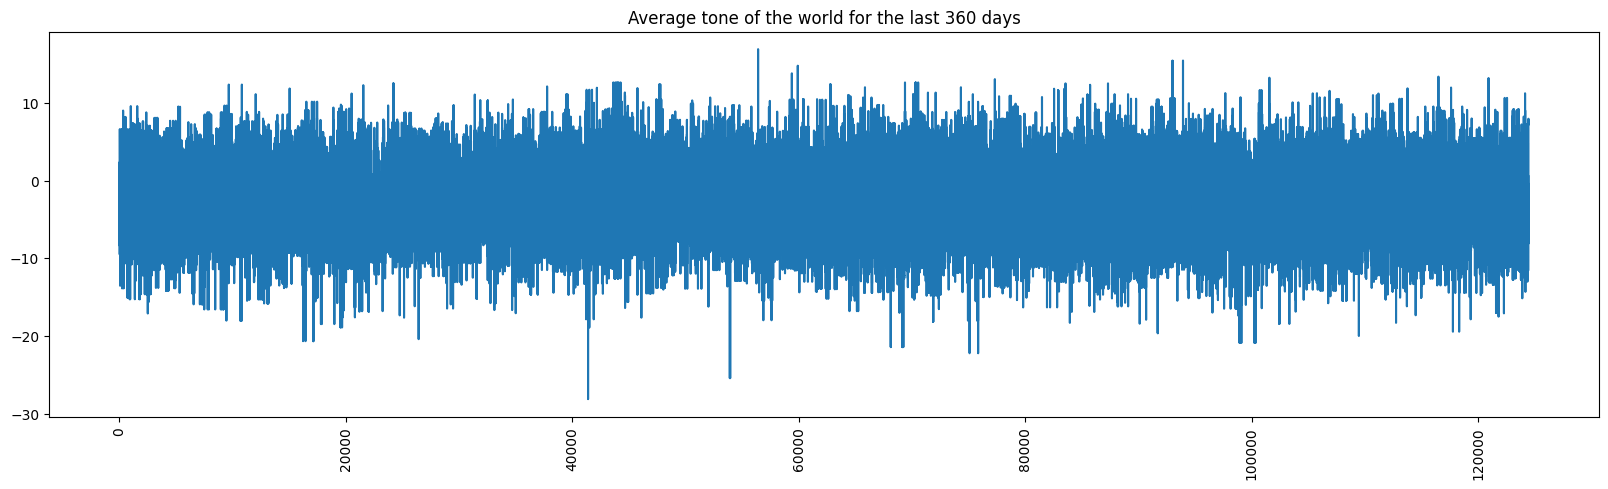

In [47]:
# Plot the average tone over time
plt.figure(figsize=(20, 5))
plt.plot(results.index, results['AvgTone'])
plt.title(f'Average tone of the world for the last {n} days')

# Rotate the x-axis labels so they don't overlap
plt.xticks(rotation=90)

plt.show()

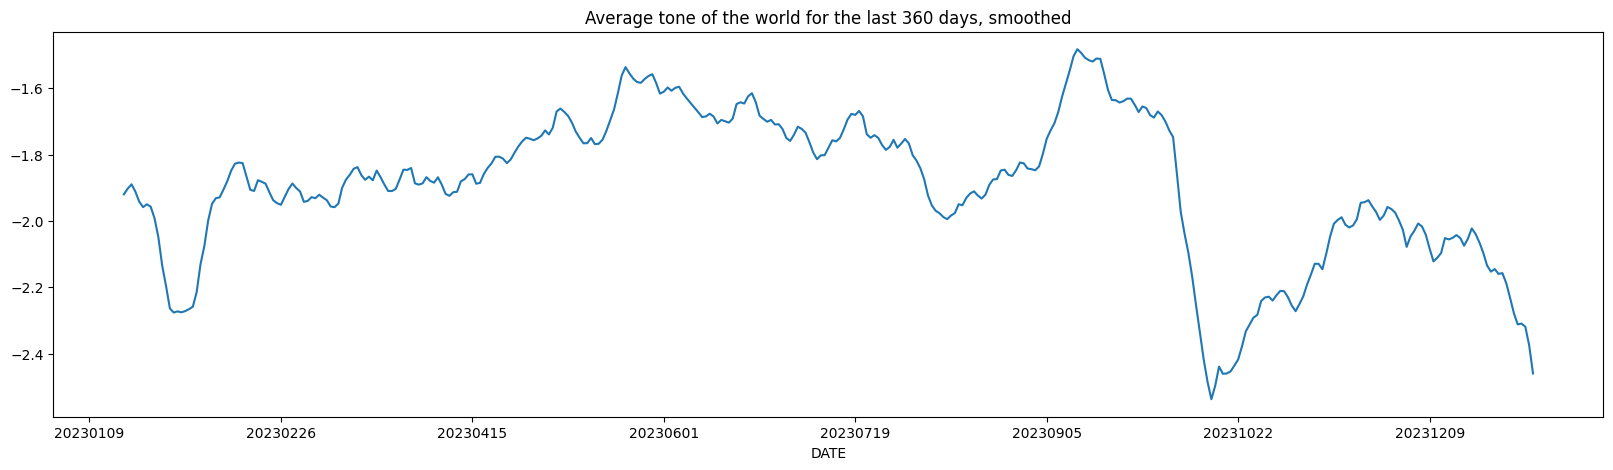

In [54]:
# The plot is too noisy, so let's smooth it out
# We'll use a rolling average
average_tones['AvgTone'].rolling(10).mean().plot(figsize=(20, 5))
plt.title(f'Average tone of the world for the last {n} days, smoothed')

# Save figure
plt.savefig('./plots/average_tone_worldwide.png')

plt.show()

As can be seen above, the Isreal Palestine conflict that started on 7th of October 2023 seriously affected the worldwide news sentiment, the dip at the beginning of the year could potentially be attribued to the earthquakes in Turkiye and Syria.

In [ ]:
# Define parameters
n = 360
country_code = 'TU'
days_per_chunk = 20

# Calculate the date range
country_current_day = pd.Timestamp.today()
first_day = country_current_day - pd.Timedelta(days=n)

# Initialize an empty DataFrame for storing average tones
country_average_tones = pd.DataFrame()

# Loop to pull data in chunks
for i in range(0, n, days_per_chunk):
    start_day = first_day + pd.Timedelta(days=i)
    end_day = min(first_day + pd.Timedelta(days=i + days_per_chunk), country_current_day)
    start_day_str = start_day.strftime('%Y %m %d')
    end_day_str = end_day.strftime('%Y %m %d')
    print(f'Getting data from {start_day_str} to {end_day_str}')
    
    # Query the data
    chunk_results = gd.Search([start_day_str, end_day_str], table='events', coverage=True).query(f'ActionGeo_CountryCode == "{country_code}"')

    # Explicitly declare as a new DataFrame to avoid SettingWithCopyWarning
    results = chunk_results.copy()

    # Process the data
    results['DATEADDED'] = results['DATEADDED'].astype(str)
    results['DATE'] = results['DATEADDED'].str[:8]

    # Calculate average tone for each date in the chunk
    chunk_averages = results.groupby('DATE').agg({'AvgTone': 'mean'})

    # Concatenate with the main DataFrame
    country_average_tones = pd.concat([country_average_tones, chunk_averages])

# Display or further process country_average_tones as needed


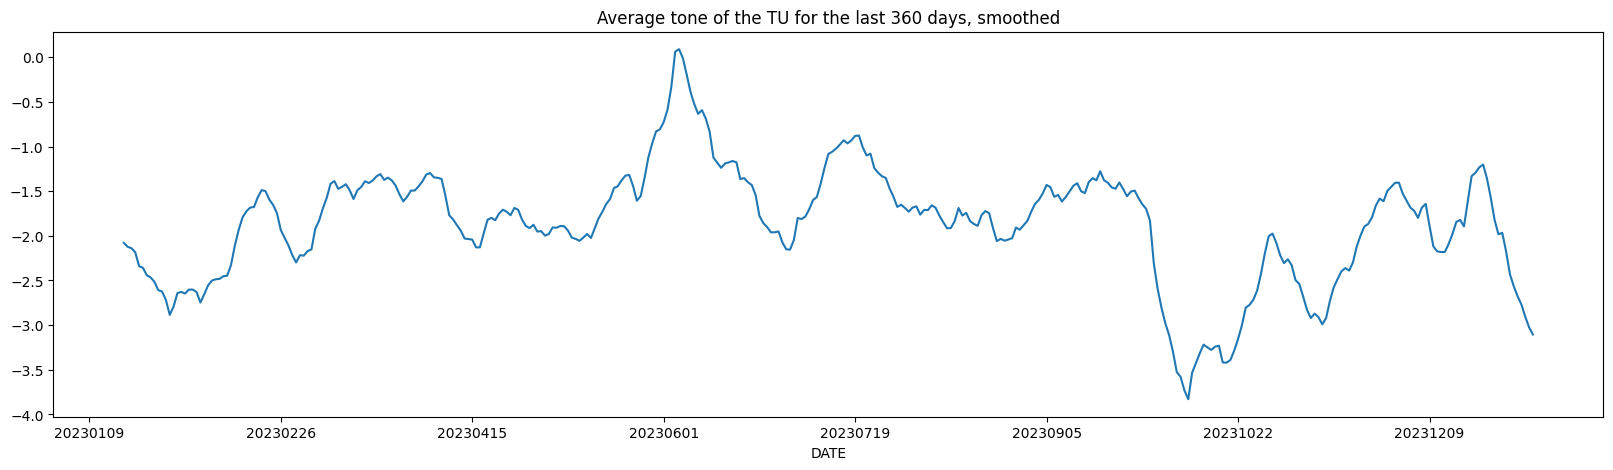

<Figure size 640x480 with 0 Axes>

In [53]:
country_average_tones['AvgTone'].rolling(10).mean().plot(figsize=(20, 5))
plt.title(f'Average tone of the {country_code} for the last {n} days, smoothed')
plt.show()

# Save figure
plt.savefig('./plots/average_tone_turkey.png')

Seems like Turkey is affected less from the February dip, so perhaps it is not solely related to the earthquake?

In [ ]:
# Define date range
initial_day = '2019 11 01'
final_day = '2020 06 30'
total_days = pd.Timestamp(final_day) - pd.Timestamp(initial_day)

chunk_size = 20

# Initialize an empty DataFrame for storing average tones
covid_average_tones = pd.DataFrame()

# Loop to pull data in chunks
for i in range(0, total_days.days, chunk_size):
    # Define the chunk's start and end day
    start_day = pd.Timestamp(initial_day) + pd.Timedelta(days=i)
    end_day = min(pd.Timestamp(start_day) + pd.Timedelta(days=chunk_size), pd.Timestamp(final_day))
    start_day_str = start_day.strftime('%Y %m %d')
    end_day_str = end_day.strftime('%Y %m %d')
    print(f'Getting data from {start_day_str} to {end_day_str}')
    
    # Query the data
    chunk_results = gd.Search([start_day_str, end_day_str], table='events', coverage=True)

    # Explicitly declare as a new DataFrame
    results = chunk_results.copy()

    # Process the data
    results['DATE'] = results['DATEADDED'].astype(str).str[:8]

    # Calculate average tone for each date in the chunk
    chunk_averages = results.groupby('DATE').agg({'AvgTone': 'mean'})

    # Concatenate with the main DataFrame
    covid_average_tones = pd.concat([covid_average_tones, chunk_averages])

In [21]:
# Put covid_average_tones in a csv file
covid_average_tones

,AvgTone
DATE,
20191101,-1.925359
20191102,-2.054164
20191103,-1.992502
20191104,-1.897679
20191105,-1.881323
...,...
20200627,-2.406408
20200628,-2.432221
20200628,-2.432221


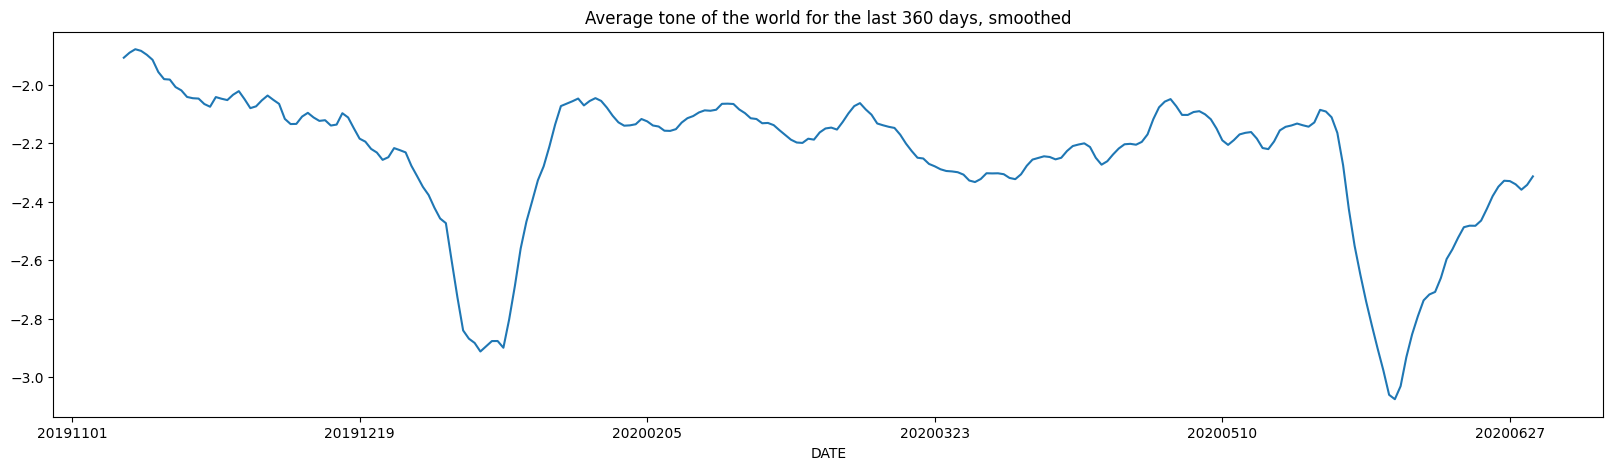

In [52]:
# Plot the covid average tone
covid_average_tones['AvgTone'].rolling(10).mean().plot(figsize=(20, 5))
plt.title(f'Average tone of the world for the last {n} days, smoothed')

# Save figure
plt.savefig('./plots/average_tone_covid.png')

plt.show()

Another clear trend... unsurprisingly, bad events cause bad news. Kind of unsurprisingly, we never get good spikes, I guess bead news make better news.

## Curiosity tanget
Let's see if there is a correlation between news tone vs S&P 500

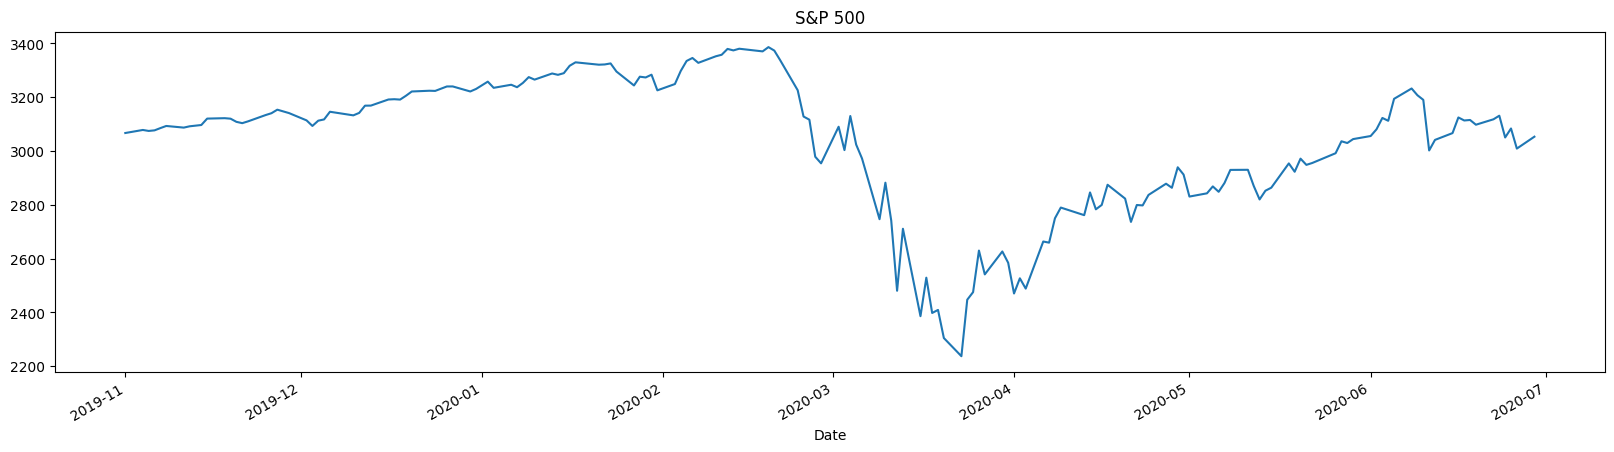

In [23]:
# Pull the S&P 500 data from yfinance for the same date range
# convert date from yyyy mm dd to yyyy-mm-dd
initial_day = initial_day.replace(' ', '-')
final_day = final_day.replace(' ', '-')
sp500 = yf.download('^GSPC', start=initial_day, end=final_day, progress=False)

# Plot the S&P 500
sp500['Close'].plot(figsize=(20, 5))
plt.title('S&P 500')
plt.show()

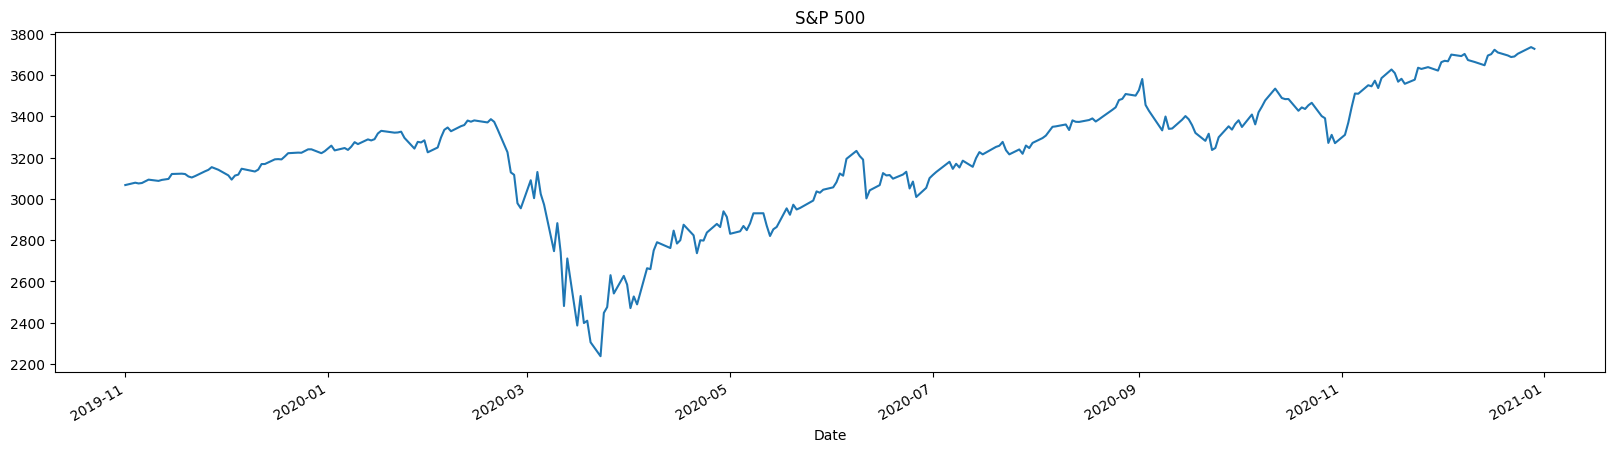

In [ ]:
# It seems like the S&P 500 is a bit late to react to the pandemic so let's plot an even bigger date range
# Define date range
final_day = '2020-12-30'

sp500 = yf.download('^GSPC', start=initial_day, end=final_day, progress=False)

# Plot the S&P 500
sp500['Close'].plot(figsize=(20, 5))
plt.title('S&P 500')
plt.show()

Ok maybe news are not a good indicator of economy...